In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 -q
%pip install -U tokenizers -q
%pip install peft transformers protobuf==3.20 bitsandbytes sentencepiece sacrebleu ipython datasets evaluate deepspeed einops wandb zstandard accelerate jsonlines trl tokenizers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.38.2 requires tokenizers<0.19,>=0.14, but you have tokenizers 0.20.1 which is incompatible.
unbabel-comet 2.2.2 requires protobuf<5.0.0,>=4.24.4, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unbabel-comet 2.2.2 requires protobuf<5.0.0,>=4.24.4, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

from peft import PeftModel, PeftConfig

from comet import download_model, load_from_checkpoint

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [23]:
import json

with open('data/translate_cpo_kiwi.json', 'r') as f:
    data = json.load(f)

In [24]:
def adequacy(en_tr, en_ref):
    return len(en_tr) / len(en_ref)

In [25]:
adequacy_score = [adequacy(item['mt'], item['ref']) for item in data]

Text(0.5, 1.0, 'Отношение длины перевода на EN к референсу EN')

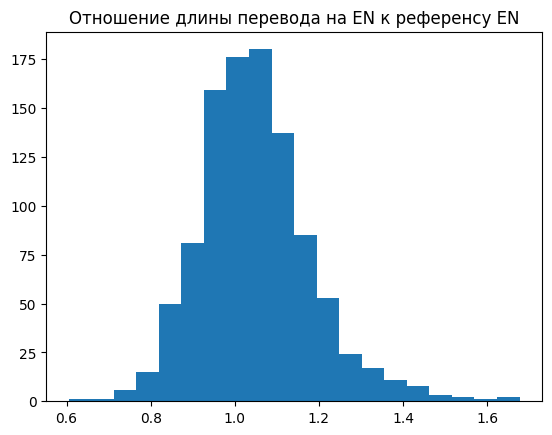

In [26]:
plt.hist(adequacy_score, bins = 20)
plt.title('Отношение длины перевода на EN к референсу EN')

In [27]:
from typing import Dict, List
from comet import download_model, load_from_checkpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model_path_xcomet = download_model("Unbabel/XCOMET-XL")
model_xcomet = load_from_checkpoint(model_path_xcomet)
model_xcomet = model_xcomet.to(device)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 53092.46it/s]
Encoder model frozen.
/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [29]:
def xcomet(data: List[Dict[str, str]]) -> List[float]:
    
    '''Format
    data = [
    {
        # Source, текст, который надо перевести, src
        "src": "В понедельник", 
        
        # Machine Translation
        "mt": "On Monday", 
        
        # Эталонный перевод, en
        "ref": "On Monday" 
    }'''
    
    
    xcomet_metric = model_xcomet.predict(data, batch_size=8, gpus=1)
    return xcomet_metric.scores

In [30]:
xcomet_cpo_score = xcomet(data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Predicting DataLoader 0: 100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


Text(0.5, 1.0, 'XCOMET')

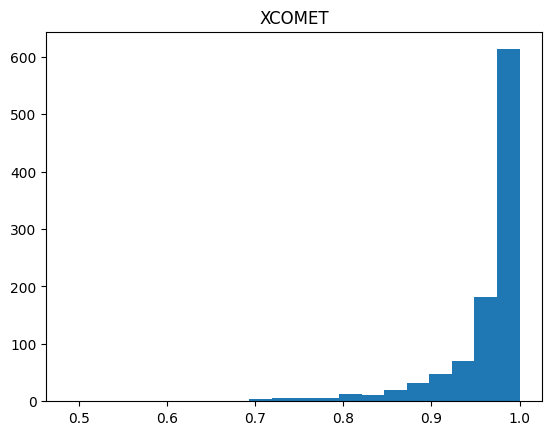

In [31]:
plt.hist(xcomet_cpo_score, bins = 20)
plt.title('XCOMET')

In [32]:
# cpo = 0.9626026108213093
# modpo = 0.9377332176762843
# alma = 0.9512363975580502

import numpy as np
np.mean(np.array(xcomet_cpo_score))

0.9625105346321118

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 

tokenizer = AutoTokenizer.from_pretrained("cointegrated/roberta-large-cola-krishna2020")
model_fluency = AutoModelForSequenceClassification.from_pretrained("cointegrated/roberta-large-cola-krishna2020")
model_fluency = model_fluency.to(device)

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [34]:
def fluency(data: str) -> float:
    return torch.softmax(model_fluency(**tokenizer(data, return_tensors="pt").to(device)).logits, dim = -1)[0][0].detach().cpu().float()

In [35]:
data_fluency = [item['mt'] for item in data]
data_fluency[0], data_fluency[1]

('Now we have four-month-old mice that no longer have diabetes," he added.',
 'According to the warning of Dr. Ehud Ur, a professor of medicine at Dalhousie University in Halifax (Nova Scotia) and the chair of the Clinical-Scientific Division of the Canadian Diabetes Association, the research is still in its early stages.')

In [36]:
fluency_cpo_score = [fluency(item) for item in data_fluency]

Text(0.5, 1.0, 'Fluency')

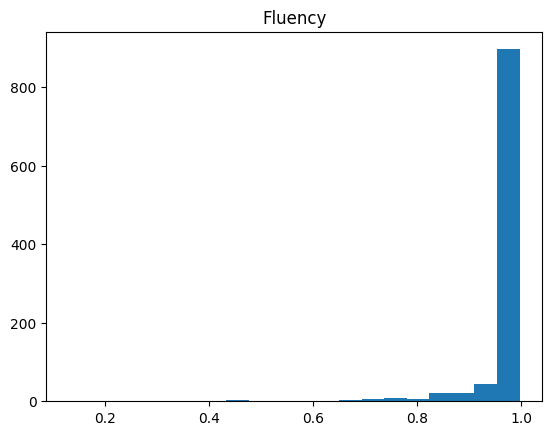

In [37]:
import matplotlib.pyplot as plt

plt.hist(fluency_cpo_score, bins = 20)
plt.title('Fluency')

In [38]:
# cpo = 0.9737626
# modpo = 0.93584627
# alma = 0.9457284 (??? 0.037422378 ???)


import numpy as np

np.mean(np.array(fluency_cpo_score))

0.972777

In [ ]:
from comet import download_model, load_from_checkpoint

model_path_kiwi = download_model("Unbabel/wmt23-cometkiwi-da-xxl")
model_kiwi = load_from_checkpoint(model_path_kiwi)
model_kiwi = model_kiwi.to(device)

def kiwi(data: List[Dict[str, str]]) -> List[float]:
    
    '''Format
    data = [
    {
        # source original text, ru
        "src": "В понедельник",
        
        # machine translation, en
        "mt": "On Monday"
    }'''
    
    
    kiwi_metric = model_kiwi.predict(data, batch_size=8, gpus=1)
    return kiwi_metric


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 42868.10 MB. The target location /tmp/xdg_cache/huggingface/hub/models--Unbabel--wmt23-cometkiwi-da-xxl/blobs only has 35737.21 MB free disk space.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 42868.10 MB. The target location /tmp/xdg_cache/huggingface/hub/models--Unbabel--wmt23-cometkiwi-da-xxl/blobs only has 35737.21 MB free disk space.
  warnings.warn(
Fetching 6 files:  50%|█████     | 3/6 [04:35<04:35, 91.77s/it]


KeyError: "Model 'Unbabel/wmt23-cometkiwi-da-xxl' not supported by COMET."

In [ ]:
data_kiwi = [(item['src'], item['mt']) for item in data]

In [ ]:
kiwi_cpo_score = kiwi(data_kiwi)

In [ ]:
print(1)